In [1]:
import torch
import pennylane as qml
from itertools import combinations
import matplotlib.pyplot as plt

# Seed Torch for reproducibility and set default tensor type
GLOBAL_SEED = 0
torch.manual_seed(GLOBAL_SEED)
torch.set_default_tensor_type(torch.DoubleTensor)

def generate_normal_time_series_set(
    p: int, num_series: int, noise_amp: float, t_init: float, t_end: float, seed: int = GLOBAL_SEED
) -> tuple:
    """Generate a normal time series data set where each of the p elements
    is drawn from a normal distribution x_t ~ N(0, noise_amp).
    """
    torch.manual_seed(seed)
    X = torch.normal(0.5, noise_amp, (num_series, p))
    T = torch.linspace(t_init, t_end, p)
    return X, T

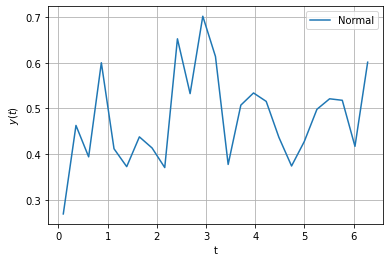

In [2]:
X_norm, T_norm = generate_normal_time_series_set(25, 25, 0.1, 0.1, 2 * torch.pi)
#Y_anom, T_anom = generate_anomalous_time_series_set(25, 25, 0.1, 0.4, 5, 0, 2 * torch.pi)

plt.figure()
plt.plot(T_norm, X_norm[0], label="Normal")
#plt.plot(T_anom, Y_anom[1], label="Anomalous")
plt.ylabel("$y(t)$")
plt.xlabel("t")
plt.grid()
leg = plt.legend()

In [3]:
def D(gamma: torch.Tensor, n_qubits: int, k: int = None, get_probs: bool = False) -> None:
    """Generates an n_qubit quantum circuit according to a k-local Walsh operator
    expansion. Here, k-local means that 1 <= k <= n of the n qubits can interact.
    See <https://doi.org/10.1088/1367-2630/16/3/033040> for more
    details. Optionally return probabilities of bit strings.
    """
    if k is None:
        k = n_qubits
    cnt = 0
    for i in range(1, k + 1):
        for comb in combinations(range(n_qubits), i):
            if len(comb) == 1:
                qml.RZ(gamma[cnt], wires=[comb[0]])
                cnt += 1
            elif len(comb) > 1:
                cnots = [comb[i : i + 2] for i in range(len(comb) - 1)]
                for j in cnots:
                    qml.CNOT(wires=j)
                qml.RZ(gamma[cnt], wires=[comb[-1]])
                cnt += 1
                for j in cnots[::-1]:
                    qml.CNOT(wires=j)
    if get_probs:
        return qml.probs(wires=range(n_qubits))

In [4]:
n_qubits = 1
dev = qml.device("default.qubit", wires=n_qubits, shots=None)
#D_test = qml.qnode(dev)(D)
#_ = qml.draw_mpl(D_test, decimals=2)(torch.tensor([1, 1, 1, 1]), n_qubits)

In [5]:
@qml.qnode(dev, interface="torch", diff_method="backprop")
def get_probs(
    xt: torch.Tensor,
    t: float,
    alpha: torch.Tensor,
    gamma: torch.Tensor,
    k: int,
    U: callable,
    W: callable,
    D: callable,
    n_qubits: int,
) -> torch.Tensor:
    """Measure the probabilities for measuring each bitstring after applying a
    circuit of the form W†DWU to the |0⟩^(⊗n) state. This
    function is defined for individual sequence elements xt.
    """
    print(alpha)
    U(xt, wires=range(n_qubits))
    W(alpha, wires=range(n_qubits))
    D(gamma * t, n_qubits, k)
    qml.adjoint(W)(alpha, wires=range(n_qubits))
    return qml.probs(range(n_qubits))

In [6]:
def get_callable_projector_func(
    k: int, U: callable, W: callable, D: callable, n_qubits: int, probs_func: callable
    ) -> callable:
    """Using get_probs() above, take only the probability of measuring the
    bitstring of all zeroes (i.e, take the projector
    |0⟩^(⊗n)⟨0|^(⊗n)) on the time devolved state.
    """
    callable_proj = lambda xt, t, alpha, gamma: probs_func(xt, t, alpha, gamma, k, U, W, D, n_qubits)[0]
    return callable_proj

In [7]:
def F(
    callable_proj: callable,
    xt: torch.Tensor,
    t: float,
    alpha: torch.Tensor,
    mu: torch.Tensor,
    sigma: torch.Tensor,
    gamma_length: int,
    n_samples: int,
) -> torch.Tensor:
    """Take the classical expecation value of of the projector on zero sampling
    the parameters of D from normal distributions. The expecation value is estimated
    with an average over n_samples.
    """
    # length of gamma should not exceed 2^n - 1
    gammas = sigma.abs() * torch.randn((n_samples, gamma_length)) + mu
    expectation = torch.empty(n_samples)
    for i, gamma in enumerate(gammas):
        expectation[i] = callable_proj(xt, t, alpha, gamma)
    return expectation.mean()

In [8]:
def callable_arctan_penalty(tau: float) -> callable:
    """Create a callable arctan function with a single hyperparameter
    tau to penalize large entries of sigma.
    """
    prefac = 1 / (torch.pi)
    callable_pen = lambda sigma: prefac * torch.arctan(2 * torch.pi * tau * sigma.abs()).mean()
    return callable_pen

In [9]:
def get_loss(
    callable_proj: callable,
    batch: torch.Tensor,
    alpha: torch.Tensor,
    mu: torch.Tensor,
    sigma: torch.Tensor,
    gamma_length: int,
    n_samples: int,
    callable_penalty: callable,
) -> torch.Tensor:
    X_batch, T_batch = batch
    loss = torch.empty(X_batch.size()[0])
    for i in range(X_batch.size()[0]):
        # unsqueeze required for tensor to have the correct dimension for PennyLane templates
        loss[i] = (
            1 - F(
                callable_proj,
                X_batch[i].unsqueeze(0),
                T_batch[i].unsqueeze(0),
                alpha,
                mu,
                sigma,
                gamma_length,
                n_samples)).square()
    return 0.5 * loss.mean() + callable_penalty(sigma)

In [10]:
def get_initial_parameters(
    W: callable, W_layers: int, n_qubits: int, seed: int = GLOBAL_SEED
) -> dict:
    """Randomly generate initial parameters. We need initial parameters for the
    variational circuit ansatz implementing W(alpha) and the standard deviation
    and mean (sigma and mu) for the normal distribution we sample gamma from.
    """
    torch.manual_seed(seed)
    init_alpha = torch.rand(W.shape(W_layers, n_qubits))
    init_mu = torch.rand(1)
    # Best to start sigma small and expand if needed
    init_sigma = torch.rand(1)
    init_params = {
        "alpha": (2 * torch.pi * init_alpha).clone().detach().requires_grad_(True),
        "mu": (2 * torch.pi * init_mu).clone().detach().requires_grad_(True),
        "sigma": (0.1 * init_sigma + 0.05).clone().detach().requires_grad_(True),
    }
    return init_params

In [11]:
def train_model_gradients(
    lr: float,
    init_params: dict,
    pytorch_optimizer: callable,
    cycler,
    n_samples: int,
    callable_penalty: callable,
    batch_iterations: int,
    callable_proj: callable,
    gamma_length: int,
    seed=GLOBAL_SEED,
    print_intermediate=False,
) -> dict:
    """Train the QVR model (minimize the loss function) with respect to the
    variational parameters using gradient-based training. You need to pass a
    PyTorch optimizer and a learning rate (lr).
    """
    torch.manual_seed(seed)
    opt = pytorch_optimizer(init_params.values(), lr=lr)
    alpha = init_params["alpha"]
    mu = init_params["mu"]
    sigma = init_params["sigma"]

    def closure():
        opt.zero_grad()
        data = next(iter(cycler))
        print(data)
        loss = get_loss(
        callable_proj, data, alpha, mu, sigma, gamma_length, n_samples, callable_penalty)
        loss.backward()
        return loss

    loss_history = []
    for i in range(batch_iterations):
        loss = opt.step(closure)
        loss_history.append(loss.item())
        if batch_iterations % 10 == 0 and print_intermediate:
            print(f"Iteration number {i}\n Current loss {loss.item()}\n")

    results_dict = {
        "opt_params": {
            "alpha": opt.param_groups[0]["params"][0],
            "mu": opt.param_groups[0]["params"][1],
            "sigma": opt.param_groups[0]["params"][2],
        },
        "loss_history": loss_history,
    }
    return results_dict

In [12]:
def make_atomized_training_set(X: torch.Tensor, T: torch.Tensor) -> list:
    """Convert input time series data provided in a two-dimensional tensor format
    to atomized tuple chunks: (xt, t).
    """
    X_flat = torch.flatten(X)
    T_flat = T.repeat(X.size()[0])
    atomized = [(xt, t) for xt, t in zip(X_flat, T_flat)]
    return atomized

def training_workflow(
    U: callable,
    W: callable,
    D: callable,
    n_qubits: int,
    k: int,
    probs_func: callable,
    W_layers: int,
    gamma_length: int,
    n_samples: int,
    p: int,
    num_series: int,
    noise_amp: float,
    t_init: float,
    t_end: float,
    batch_size: int,
    tau: float,
    pytorch_optimizer: callable,
    lr: float,
    batch_iterations: int,
):
    X, T = generate_normal_time_series_set(p, num_series, noise_amp, t_init, t_end)
    Xtr = make_atomized_training_set(X, T)
    cycler = torch.utils.data.DataLoader(Xtr, batch_size=batch_size, shuffle=True)
    init_params = get_initial_parameters(W, W_layers, n_qubits)
    callable_penalty = callable_arctan_penalty(tau)
    callable_proj = get_callable_projector_func(k, U, W, D, n_qubits, probs_func)
    results_dict = train_model_gradients(
        lr,
        init_params,
        pytorch_optimizer,
        cycler,
        n_samples,
        callable_penalty,
        batch_iterations,
        callable_proj,
        gamma_length,
        print_intermediate=False,
    )
    return results_dict

In [13]:
general_options = {
    "U": qml.AngleEmbedding,
    "W": qml.StronglyEntanglingLayers,
    "D": D,
    "n_qubits": 1,
    "probs_func": get_probs,
    "gamma_length": 1,
    "n_samples": 10,
    "p": 25,
    "num_series": 25,
    "noise_amp": 0.1,
    "t_init": 0.1,
    "t_end": 2 * torch.pi,
    "k": 1,
}

training_options = {
    "batch_size": 10,
    "tau": 5,
    "pytorch_optimizer": torch.optim.Adam,
    "lr": 0.01,
    "batch_iterations": 50,
    "W_layers": 2,
}

training_options.update(general_options)

In [14]:
results_dict = training_workflow(**training_options)

[tensor([0.4223, 0.4914, 0.4252, 0.3880, 0.5381, 0.4452, 0.6422, 0.4664, 0.5524,
        0.5286]), tensor([0.3576, 4.7374, 6.2832, 3.1916, 1.9034, 1.6458, 1.6458, 1.3882, 0.1000,
        4.7374])]
tensor([[[6.0950, 4.4474, 2.8864]],

        [[5.7852, 4.0528, 4.9709]]], requires_grad=True)
tensor([[[6.0950, 4.4474, 2.8864]],

        [[5.7852, 4.0528, 4.9709]]], requires_grad=True)
tensor([[[6.0950, 4.4474, 2.8864]],

        [[5.7852, 4.0528, 4.9709]]], requires_grad=True)
tensor([[[6.0950, 4.4474, 2.8864]],

        [[5.7852, 4.0528, 4.9709]]], requires_grad=True)
tensor([[[6.0950, 4.4474, 2.8864]],

        [[5.7852, 4.0528, 4.9709]]], requires_grad=True)
tensor([[[6.0950, 4.4474, 2.8864]],

        [[5.7852, 4.0528, 4.9709]]], requires_grad=True)
tensor([[[6.0950, 4.4474, 2.8864]],

        [[5.7852, 4.0528, 4.9709]]], requires_grad=True)
tensor([[[6.0950, 4.4474, 2.8864]],

        [[5.7852, 4.0528, 4.9709]]], requires_grad=True)
tensor([[[6.0950, 4.4474, 2.8864]],

        [[5.78

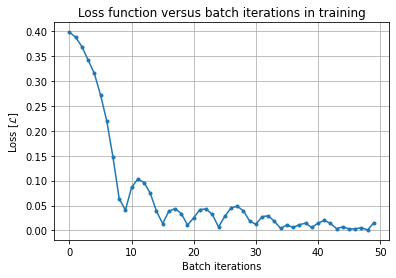

In [15]:
plt.figure()
plt.plot(results_dict["loss_history"], ".-")
plt.ylabel("Loss [$\mathcal{L}$]")
plt.xlabel("Batch iterations")
plt.title("Loss function versus batch iterations in training")
plt.grid()

In [16]:
print(results_dict["opt_params"])

{'alpha': tensor([[[5.9575, 4.2705, 3.1134]],

        [[6.0122, 4.2136, 4.9709]]], requires_grad=True), 'mu': tensor([1.2247], requires_grad=True), 'sigma': tensor([-0.0017], requires_grad=True)}


tensor([[[5.9565, 4.2699, 3.1124]],

        [[6.0113, 4.2146, 4.9709]]])


(<Figure size 504x144 with 1 Axes>, <Axes: >)

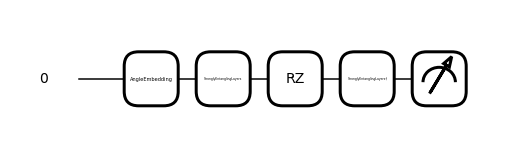

In [22]:
qml.draw_mpl(get_probs)(
    torch.tensor([1]),
    0,
    results_dict["opt_params"]["alpha"],
    torch.tensor([1]),
    1,
    qml.AngleEmbedding,
    qml.StronglyEntanglingLayers,
    D,
    1,
)